# Imports

In [133]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from mnOPSuite.PRISM.python import scandelay_FTIR as sd
from importlib import reload

from scipy.optimize import leastsq,minimize
from scipy.interpolate import interp1d
from common import numerical_recipes as numrec
import time

dX=None
flattening_order=10
Nx=20
interp_kwargs=dict(bounds_error=False,
                   fill_value=0,
                   kind='cubic')
delay_calibration_factor=2.403

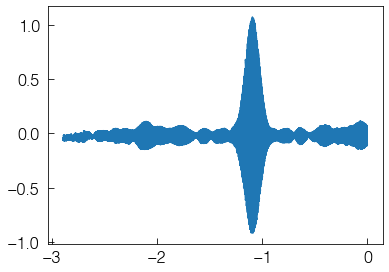

In [58]:
intfgs_arr=np.loadtxt('interferograms.txt')
plt.figure()
i=0
plt.plot(intfgs_arr[2*i+1],intfgs_arr[2*i])

# Rolling alignment

In [65]:
intfgs=[]
xs=[]

Ncycles = len(intfgs_arr) // 2
Nintfgms = Ncycles*2
Nx=100

all_xs = []
all_intfgs = []
for i in range(Ncycles):
    ys, xs = np.array(intfgs_arr[2 * i:2 * (i+1)])
    N = len(xs)

    #fwd:
    x = xs[:int(N // 2)]
    y = ys[:int(N // 2)]
    
    x = numrec.smooth(x,window_len=Nx,axis=0)
    x,y=zip(*sorted(zip(x,y)))
    x=np.array(x); y=np.array(y)
    y-=np.polyval(np.polyfit(x=x,y=y,deg=flattening_order),x)
    if i==0:
        x0=np.array(x)
        intfg0=np.array(y)
        
    all_xs.append(x); all_intfgs.append(y)
    #bwd
    #x = xs[int(N // 2):]
    #y = ys[int(N // 2):]
    #all_xs.append(x); all_intfgs.append(y)
    
all_xs=np.array(all_xs)
all_xs *= delay_calibration_factor
x0 *= delay_calibration_factor
    

def roll_intfgs(rs):
    
    intfgs_rolled=[]
    for r,intfg in zip(rs,all_intfgs):
        intfg_rolled=np.roll(intfg,int(r))
        intfgs_rolled.append(intfg_rolled)
        
    return np.array(intfgs_rolled)

def roll_xs(rs):
    
    xs_rolled=[]
    for r,x in zip(rs,all_xs):
        x_rolled=np.roll(x,int(r))
        xs_rolled.append(x_rolled)
        
    return np.array(xs_rolled)

def to_minimize(rs):
    
    intfgs_rolled=roll_intfgs(rs)
    
    return -np.sum(intfgs_rolled**2)

   
rs=minimize(to_minimize,[0]*Nintfgms).x
intfg_new = np.mean(roll_intfgs(rs),axis=0)
xnew = np.mean(roll_xs(rs),axis=0)
intfg_interp = interp1d(x=xnew,y=intfg_new,**interp_kwargs)

x1=np.min(all_xs)
if dX is None:
    dX=np.max(all_xs)-x1
    
xnew1 = np.linspace(x1,x1+dX,len(xnew))
intfg_new1=intfg_interp(xnew1)
    


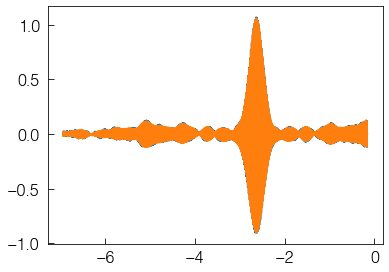

In [60]:
#plt.plot(x)
plt.figure()
plt.plot(x0,intfg0)#,x,intfg1)
plt.plot(xnew1,intfg_new1)#,x,intfg1)
#plt.xlim(-1.15,-1.05)
#plt.ylim(-2.7,-2)

<common.numerics.Spectrum.__new__>:
	Interpolating to evenly-spaced samples along *axis*.


(1500.0, 1800.0)

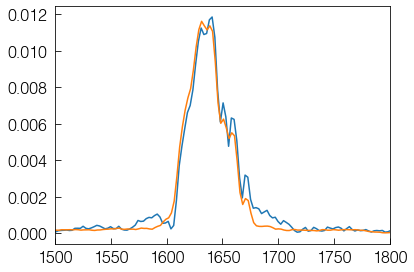

In [61]:
result0=sd.fourier_xform([intfg0,x0],tsubtract=0,envelope=True)
result1=sd.fourier_xform([intfg_new1,xnew1],tsubtract=0,envelope=True)
plt.figure()
plt.plot(result0[0],result0[1])
plt.plot(result1[0],result1[1])

plt.xlim(1500,1800)

# Shifting alignment

In [71]:
intfgs_arr=np.loadtxt('interferograms.txt')

Ncycles = len(intfgs_arr) // 2
Ncycles = np.min((20,Ncycles))
Nintfgms = Ncycles*2

all_xs = []
all_intfg_interps = []
for i in range(Ncycles):
    #i=i+10
    ys, xs = np.array(intfgs_arr[2 * i:2 * (i+1)])
    N = len(xs)

    #fwd:
    x = xs[:int(N // 2)]*delay_calibration_factor
    y = ys[:int(N // 2)]
    x = numrec.smooth(x,window_len=Nx,axis=0)
    x,y=zip(*sorted(zip(x,y)))
    x=np.array(x); y=np.array(y)
    y-=np.polyval(np.polyfit(x=x,y=y,deg=flattening_order),x)
    if i==0:
        x0=np.array(x)
        intfg0=np.array(y)
    all_xs.append(x)
    all_intfg_interps.append( interp1d(x=x,y=y,**interp_kwargs) )
    #bwd
    #x = xs[int(N // 2):]
    #y = ys[int(N // 2):]
    #all_xs.append(x); all_intfgs.append(y)
    
all_xs=np.array(all_xs)
    
x1=np.min(all_xs)
x2=np.max(all_xs)
if dX is None: dX = x2-x1

def get_dx(x):
    
    wl = 2*dX
    return np.sin(2*np.pi*(x-x1)/wl)
    
def get_intfg_shifted(rs):
    
    intfgs_shifted=[]
    for r,x,intfg_interp in zip(rs,all_xs,all_intfg_interps):
        dx=get_dx(x)
        intfg_rolled=intfg_interp(x+r*dx)
        intfgs_shifted.append(intfg_rolled)
        
    return np.mean(intfgs_shifted,axis=0)

def get_x_shifted(rs):
    
    xs_shifted=[]
    for r,x in zip(rs,all_xs):
        dx=get_dx(x)
        xs_shifted.append(x+r*dx)
        
    return np.mean(xs_shifted,axis=0)

def to_minimize(rs):
    
    intfg_shifted=get_intfg_shifted(rs)
    
    return -np.sum(intfg_shifted**2)
   
t=time.time()
rs=minimize(to_minimize,[0]*Nintfgms,
           bounds=[(-.01,.01)]*Nintfgms,
           tol=1e-5).x
intfg =get_intfg_shifted(rs)
x = get_x_shifted(rs)
print('Time elapsed:',time.time()-t)

interp = interp1d(x=x,y=intfg,**interp_kwargs)
xnew2=x=np.linspace(x1,x1+dX,len(x))
intfg_new2 = interp(xnew2)
    


Time elapsed: 19.52706480026245


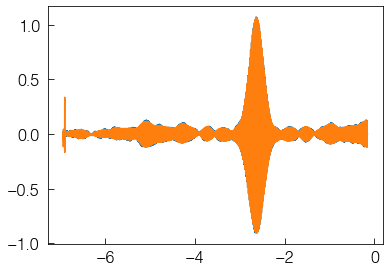

In [73]:
#plt.plot(x)
plt.figure()
plt.plot(x0,intfg0)#,x,intfg1)
plt.plot(xnew2,intfg_new2)#,x,intfg1)
#plt.xlim(-3.3,-3)
#plt.ylim(-2.7,-2)

(1600.0, 1700.0)

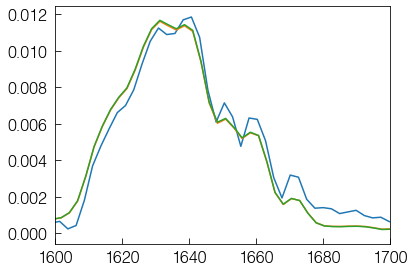

In [74]:
#result0=sd.fourier_xform([intfg0,x0],tsubtract=0,envelope=True)
result2=sd.fourier_xform([intfg_new2,xnew2],tsubtract=0,envelope=True)
plt.figure()
plt.plot(result0[0],result0[1])
plt.plot(result1[0],result1[1])
plt.plot(result2[0],result2[1])

plt.xlim(1600,1700)

# Simple mean of fwd/bwd

In [75]:
Ncycles = len(intfgs_arr) // 2
Nintfgms = Ncycles*2
Nx=100

all_xs_fwd = []
all_intfgs_fwd = []
all_xs_bwd = []
all_intfgs_bwd = []

for i in range(Ncycles):
    ys, xs = np.array(intfgs_arr[2 * i:2 * (i+1)])
    xs*=delay_calibration_factor
    xs = numrec.smooth(xs,window_len=Nx,axis=0)
    
    indmin=np.argmin(xs)
    indmax=np.argmax(xs)
    
    
    

    #-- fwd:
    x = xs[:int(N // 2)]
    y = ys[:int(N // 2)]
    
    x,y=zip(*sorted(zip(x,y)))
    x=np.array(x); y=np.array(y)
    y-=np.polyval(np.polyfit(x=x,y=y,deg=flattening_order),x)
    
    if i==0:
        x0=np.array(x)
        intfg0=np.array(y)
        
    all_xs_fwd.append(x); all_intfgs_fwd.append(y)
    
    #-- bwd
    x = xs[int(N // 2):]
    y = ys[int(N // 2):]
    
    x = numrec.smooth(x,window_len=Nx,axis=0)
    x,y=zip(*sorted(zip(x,y)))
    x=np.array(x); y=np.array(y)
    y-=np.polyval(np.polyfit(x=x,y=y,deg=flattening_order),x)
        
    all_xs_bwd.append(x); all_intfgs_bwd.append(y)
    
x_fwd=np.mean(all_xs_fwd,axis=0)
x_bwd=np.mean(all_xs_bwd,axis=0)
intfg_fwd=np.mean(all_intfgs_fwd,axis=0)
intfg_bwd=np.mean(all_intfgs_bwd,axis=0)

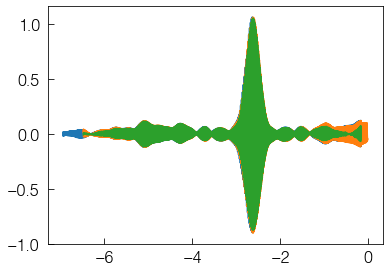

In [82]:
plt.plot(x_fwd,intfg_fwd)
plt.plot(x_bwd,intfg_bwd)

interp_fwd=interp1d(x=x_fwd,y=intfg_fwd,
                   **interp_kwargs)
interp_bwd=interp1d(x=x_bwd,y=intfg_bwd,
                   **interp_kwargs)
xcommon=np.linspace( np.max( (np.min(x_fwd),np.min(x_bwd)) ),
                     np.min( (np.max(x_fwd),np.max(x_bwd)) ),
                     int( np.mean( (len(x_fwd),len(x_bwd)) ) ) )
intfg_new = (interp_fwd(xcommon)+interp_bwd(xcommon))/2

plt.plot(xcommon,intfg_new)
#plt.xlim(-2.8,-2.6)

# Binning with global shift

In [135]:
from scipy.stats import binned_statistic
intfgs_arr=np.loadtxt('interferograms.txt')

Ncycles = len(intfgs_arr) // 2
print('Ncycles:',Ncycles)
Ncycles = np.min((200,Ncycles))
Nintfgms = Ncycles*2

all_xs = []
all_ys = []
for i in range(Ncycles):
    #i=i+10
    ys, xs = np.array(intfgs_arr[2 * i:2 * (i+1)])
    Nbins=len(xs)
    
    xs *= delay_calibration_factor
    xs = numrec.smooth(xs,window_len=Nx,axis=0)
    ys-=np.polyval(np.polyfit(x=xs,y=ys,deg=flattening_order),xs)
    
    if i==0:
        x0=xs
        y0=ys

    all_xs = np.append(all_xs,xs)
    all_ys = np.append(all_ys,ys)
    
def shifted_intfg(shift):
    
    all_xs_rolled=np.roll(all_xs,shift,axis=0)
    result = binned_statistic(all_xs_rolled,all_ys,bins=Nbins)
    xnew = result.bin_edges[:-1]
    intfg_new=result.statistic
    
    return xnew,intfg_new
    
    

shifts=np.arange(-50,50,1)
sums=[]
for shift in shifts:
    print(shift)
    xnew,intfg_new=shifted_intfg(shift)
    sums.append(np.sum(intfg_new**2))
sums=np.array(sums)
    
shift=shifts[np.argmax(sums)]
xnew3,intfg_new3 = shifted_intfg(shift)
print('Optimal shift:',shift)

print('Optimal sum:',np.max(sums))


Ncycles: 100
-50
-49
-48
-47
-46
-45
-44
-43
-42
-41
-40
-39
-38
-37
-36
-35
-34
-33
-32
-31
-30
-29
-28
-27
-26
-25
-24
-23
-22
-21
-20
-19
-18
-17
-16
-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Optimal shift: -5
Optimal sum: 70.3684924441586


Text(0.5, 1.0, 'Optimal shift for envelope: -50')

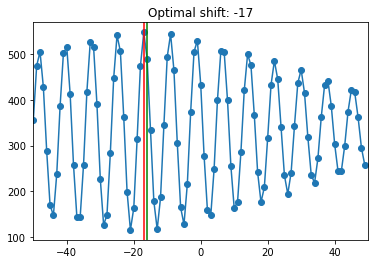

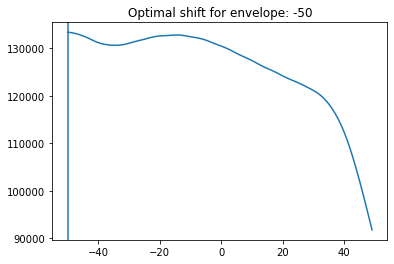

In [128]:
plt.plot(shifts,sums,marker='o')
plt.axvline(shift,color='r')
plt.title('Optimal shift: %s'%shift)
plt.axvline(-16,color='g')
plt.xlim(-50,50)

plt.figure()
env=numrec.smooth(sums**2,window_len=50)
idx=np.argmax(env)
shift_env=shifts[idx]
plt.axvline(shift_env)
plt.plot(shifts,numrec.smooth(sums**2,window_len=50))
plt.title('Optimal shift for envelope: %s'%shift_env)

In [129]:
sums3=sums

(-50.0, 50.0)

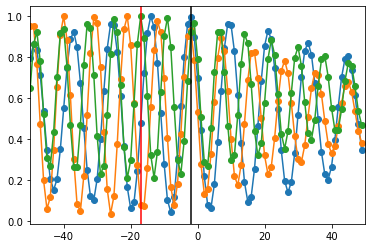

In [132]:
plt.plot(shifts,sums1/sums1.max(),marker='o')
plt.plot(shifts,sums2/sums2.max(),marker='o')
plt.plot(shifts,sums3/sums3.max(),marker='o')
plt.axvline(shift,color='r')
#plt.title('Optimal shift: %s'%shift)
plt.axvline(-2,color='k')
plt.xlim(-50,50)

(-0.1, 0.1)

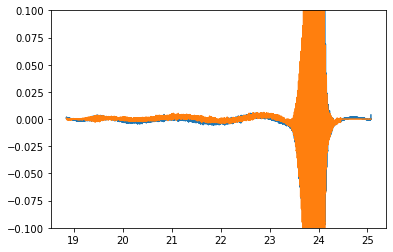

In [175]:
reload(sd)

result = sd.align_interferograms_fwd_bwd(intfgs_arr, delay_calibration_factor=-2.6,
                         delay0=0,optimize_delay=False,delay_range=15,
                         flattening_order=20)
plt.plot(result[1],result[0])
plt.plot(result[3],result[2])
plt.ylim(-.1,.1)

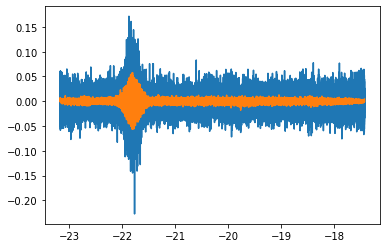

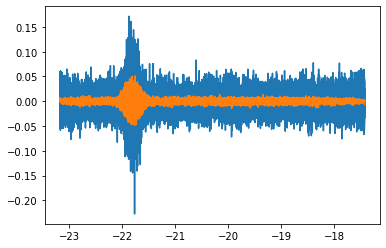

In [57]:
plt.plot(x0,y0)
plt.plot(xnew3,intfg_new3)

plt.figure()
plt.plot(x0,y0)
plt.plot(*shifted_intfg(-15))
#plt.xlim(-2.8,-2.6)

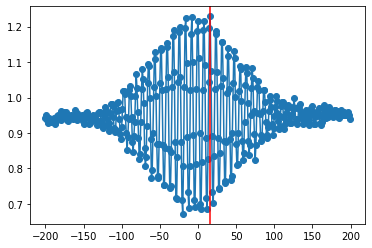

In [6]:
plt.plot(shifts,sums,marker='o')
plt.axvline(shift,color='r')
#plt.ylim(4,32)

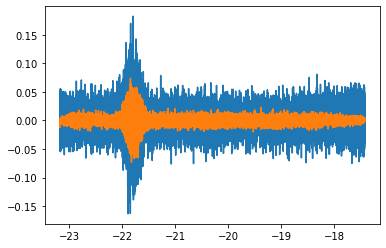

In [7]:
plt.plot(x0,y0)
plt.plot(xnew3,intfg_new3)
#plt.xlim(-2.8,-2.6)

(1600.0, 1700.0)

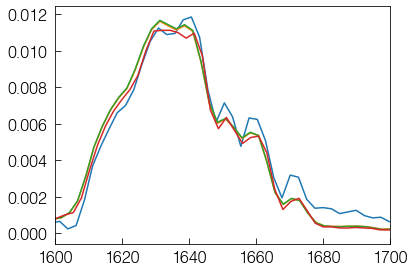

In [116]:
#result0=sd.fourier_xform([intfg0,x0],tsubtract=0,envelope=True)
result3=sd.fourier_xform([intfg_new3,xnew3],tsubtract=0,envelope=True)
plt.figure()
plt.plot(result0[0],result0[1])
plt.plot(result1[0],result1[1])
plt.plot(result2[0],result2[1])
plt.plot(result3[0],result3[1])

plt.xlim(1600,1700)

In [113]:
np.roll?

In [1]:
a=1